In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# --- 1. Load metadata and keep only KOs ---
metadata_df = pd.read_csv("../data/raw/messner/yeast5k_metadata.csv")
ko_meta = metadata_df[metadata_df["sampletype"] == "ko"].copy()

# --- 2. Load growth rates and merge by ORF ---
growth_df = pd.read_csv("../data/raw/messner/yeast5k_growthrates_byORF.csv")
growth_df = growth_df.rename(columns={"orf": "ORF"})

# LEFT join: keep all KOs, even if some growth values are missing
ko_meta = ko_meta.merge(growth_df, on="ORF", how="left")

# IMPORTANT: do NOT drop NaNs if you want all strains/samples
ko_meta = ko_meta.dropna(subset=["SM", "SC", "YPD"])   # <-- remove this line

# --- 3. Build the growth dataframe for all media and all KO samples ---
# index by Filename (or ORF if you prefer)
growths_df = ko_meta.set_index("Filename")[["SM", "SC", "YPD"]]


growths_df

,SM,SC,YPD
Filename,,,
10_9_hpr1_ko_YAL059W_ECM1_0.47,0.949037,0.928565,0.890213
10_9_hpr10_ko_YBR174C_YBR174c_0.23,0.846905,0.873245,0.891047
10_9_hpr11_ko_YDR078C_SHU2_0.36,0.795139,0.996356,0.840004
10_9_hpr12_ko_YDR389W_SAC7_0.16,0.747030,0.648519,0.875060
10_9_hpr14_ko_YHR048W_YHK8_0.40,1.026152,0.955856,0.960585
...,...,...,...
99_92_hpr6_ko_YOR083W_WHI5_-0.15,0.812612,0.769824,0.994689
99_92_hpr7_ko_YOL013C_HRD1_0.68,0.961501,1.030742,0.995031
99_92_hpr8_ko_YPL229W_YPL229w_0.53,0.957038,0.985125,1.025886


In [ ]:
# --- 4. Convert Filename to gene id  ---

df = pd.read_csv("../data/raw/messner/yeast5k_impute_wide.csv")
ko_filenames = ko_meta["Filename"].tolist()
proteomics_ko = df[["Protein.Group"] + ko_filenames].copy()

prot_df = proteomics_ko.set_index("Protein.Group").T

# turn index into Series so we can parse it
sample_ids = prot_df.index.to_series()
# split on '_' and take second-from-last token as gene name (ECM1 in example)
prot_gene_names = sample_ids.str.split("_").str[-2]
prot_gene_names.name = "gene"

# build an annotation table for proteomics samples: sample_id -> gene
prot_annot = pd.DataFrame({"sample_id": sample_ids, "gene": prot_gene_names}).set_index(
    "sample_id"
)

prot_annot

,gene
sample_id,
10_9_hpr1_ko_YAL059W_ECM1_0.47,ECM1
10_9_hpr10_ko_YBR174C_YBR174c_0.23,YBR174c
10_9_hpr11_ko_YDR078C_SHU2_0.36,SHU2
10_9_hpr12_ko_YDR389W_SAC7_0.16,SAC7
10_9_hpr14_ko_YHR048W_YHK8_0.40,YHK8
...,...
99_92_hpr6_ko_YOR083W_WHI5_-0.15,WHI5
99_92_hpr7_ko_YOL013C_HRD1_0.68,HRD1
99_92_hpr8_ko_YPL229W_YPL229w_0.53,YPL229w


In [4]:
# Attach gene to growths_df
growths_with_gene = growths_df.join(prot_annot, how="left")

#  Set gene as the index:
g_df= growths_with_gene.set_index("gene")[["SM", "SC", "YPD"]]
g_df

,SM,SC,YPD
gene,,,
ECM1,0.949037,0.928565,0.890213
YBR174c,0.846905,0.873245,0.891047
SHU2,0.795139,0.996356,0.840004
SAC7,0.747030,0.648519,0.875060
YHK8,1.026152,0.955856,0.960585
...,...,...,...
WHI5,0.812612,0.769824,0.994689
HRD1,0.961501,1.030742,0.995031
YPL229w,0.957038,0.985125,1.025886


In [5]:
pearson_SC_SM = g_df["SC"].corr(g_df["SM"], method="pearson")
pearson_SC_YPD = g_df["SC"].corr(g_df["YPD"], method="pearson")
pearson_SM_YPD = g_df["SM"].corr(g_df["YPD"], method="pearson")

spearman_SC_SM = g_df["SC"].corr(g_df["SM"], method="spearman")
spearman_SC_YPD = g_df["SC"].corr(g_df["YPD"], method="spearman")
spearman_SM_YPD = g_df["SM"].corr(g_df["YPD"], method="spearman")


data = {
    "Comparison": ["SC vs SM", "SC vs YPD", "SM vs YPD"],
    "Pearson": [pearson_SC_SM, pearson_SC_YPD, pearson_SM_YPD],
    "Spearman": [spearman_SC_SM, spearman_SC_YPD, spearman_SM_YPD],
}
df_corr = pd.DataFrame(data)
df_corr

,Comparison,Pearson,Spearman
0,SC vs SM,0.873836,0.790807
1,SC vs YPD,0.703673,0.529183
2,SM vs YPD,0.743754,0.585119


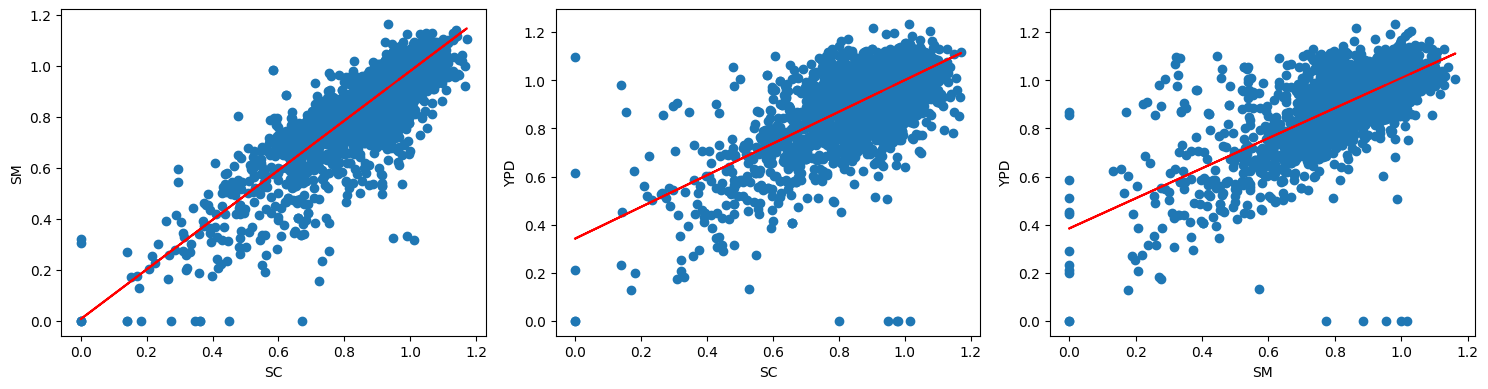

In [6]:
x = g_df["SC"]
y = g_df["SM"]
z = g_df["YPD"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(x, y)
axes[0].set_xlabel("SC"); axes[0].set_ylabel("SM")
m0, b0 = np.polyfit(x, y, 1)
axes[0].plot(x, m0*x +b0, color="red")

axes[1].scatter(x, z)
axes[1].set_xlabel("SC"); axes[1].set_ylabel("YPD")
m1, b1 = np.polyfit(x, z, 1)
axes[1].plot(x, m1 * x + b1, color="red")

axes[2].scatter(y, z)
axes[2].set_xlabel("SM"); axes[2].set_ylabel("YPD")
m2, b2 = np.polyfit(y, z, 1)
axes[2].plot(y, m2 * y + b2, color="red")

plt.tight_layout()
plt.show()

In [7]:
# ------------------------------------------------------------------
# 1) Compute pairwise Δ-growth
# ------------------------------------------------------------------
# For each strain (row), compute differences between media
delta_df = pd.DataFrame(
    {
        "Δ_SC_minus_SM": g_df["SC"] - g_df["SM"],
        "Δ_SC_minus_YPD": g_df["SC"] - g_df["YPD"],
        "Δ_SM_minus_YPD": g_df["SM"] - g_df["YPD"],
    },
    index=g_df.index,
)

delta_df.head()

,Δ_SC_minus_SM,Δ_SC_minus_YPD,Δ_SM_minus_YPD
gene,,,
ECM1,-0.020472,0.038352,0.058824
YBR174c,0.026340,-0.017802,-0.044143
SHU2,0.201218,0.156353,-0.044865
SAC7,-0.098511,-0.226542,-0.128031
YHK8,-0.070296,-0.004729,0.065567


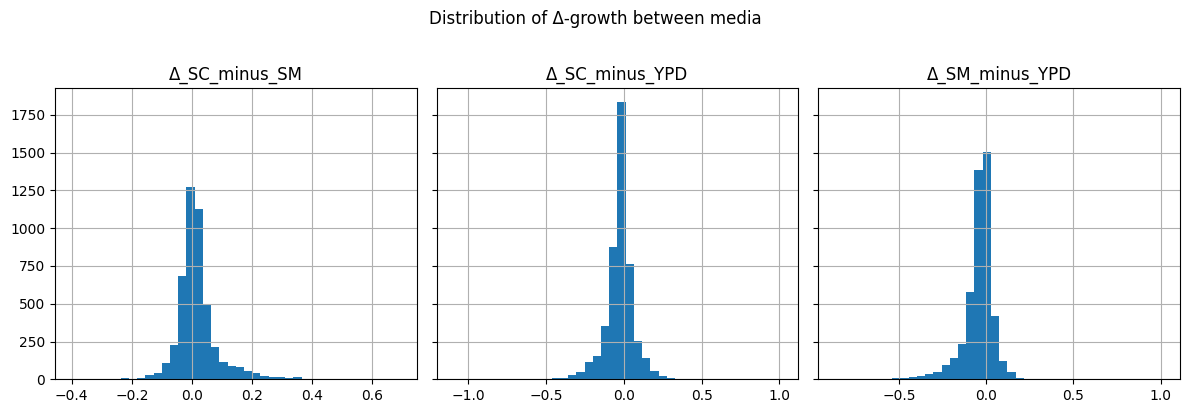

In [8]:
# Histograms of Δ-growth
ax = delta_df.hist(bins=40, figsize=(12, 4), layout=(1, 3), sharey=True)
plt.suptitle("Distribution of Δ-growth between media", y=1.02)
plt.tight_layout()
plt.show()

In [10]:
delta_stats = delta_df.agg(["mean", "median", "std", "min", "max"])
delta_stats

,Δ_SC_minus_SM,Δ_SC_minus_YPD,Δ_SM_minus_YPD
mean,0.017915,-0.024796,-0.042711
median,0.008154,-0.018246,-0.026334
std,0.072967,0.100615,0.101251
min,-0.401208,-1.096435,-0.868243
max,0.692766,1.015751,1.016898


In [ ]:
sm_subset_df = pd.read_csv("../data/processed/y_messner.csv").drop(
    columns=["growth"]
)  # 965 rows × 2 columns
# g_df  # 4699 rows × 3 columns

# Attach gene to growths_df using prot_annot
g_intersection = g_df.merge(
    sm_subset_df, left_index=True, right_on="KO", how="inner"
) # 983 rows × 5 columns

# Collapse to one row per gene, averaging across filenames/replicates
g_subset_df = g_intersection.groupby("KO")[["SM", "SC", "YPD"]].mean()
g_subset_df

,SM,SC,YPD,KO
177,0.949037,0.928565,0.890213,ECM1
4,1.003542,1.009234,0.982785,ACO1
266,0.823221,0.743129,0.855808,HDA3
741,0.991949,1.026281,0.948054,SKO1
517,0.895763,0.903787,1.046083,PCL9
...,...,...,...,...
203,0.958312,0.979897,1.063478,FAA4
566,1.006375,1.009840,1.137218,PPS1
45,0.952728,0.915432,0.871330,BCK2
289,0.961501,1.030742,0.995031,HRD1


In [13]:
pearson_SC_SM = g_subset_df["SC"].corr(g_subset_df["SM"], method="pearson")
pearson_SC_YPD = g_subset_df["SC"].corr(g_subset_df["YPD"], method="pearson")
pearson_SM_YPD = g_subset_df["SM"].corr(g_subset_df["YPD"], method="pearson")

spearman_SC_SM = g_subset_df["SC"].corr(g_subset_df["SM"], method="spearman")
spearman_SC_YPD = g_subset_df["SC"].corr(g_subset_df["YPD"], method="spearman")
spearman_SM_YPD = g_subset_df["SM"].corr(g_subset_df["YPD"], method="spearman")


data = {
    "Comparison": ["SC vs SM", "SC vs YPD", "SM vs YPD"],
    "Pearson": [pearson_SC_SM, pearson_SC_YPD, pearson_SM_YPD],
    "Spearman": [spearman_SC_SM, spearman_SC_YPD, spearman_SM_YPD],
}
df_corr = pd.DataFrame(data)
df_corr

,Comparison,Pearson,Spearman
0,SC vs SM,0.871237,0.826688
1,SC vs YPD,0.696810,0.564100
2,SM vs YPD,0.724968,0.575948


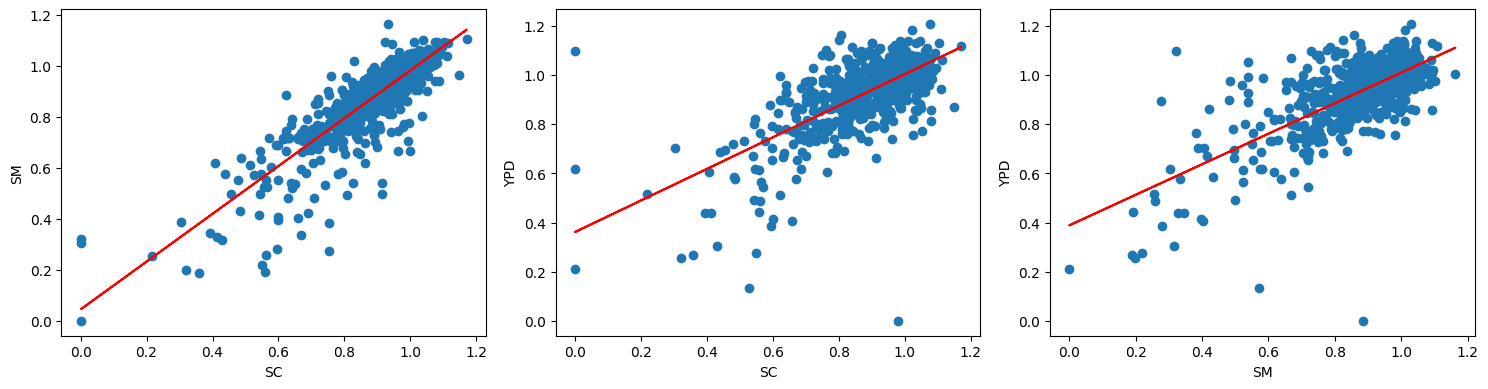

In [14]:
x = g_subset_df["SC"]
y = g_subset_df["SM"]
z = g_subset_df["YPD"]

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].scatter(x, y)
axes[0].set_xlabel("SC")
axes[0].set_ylabel("SM")
m0, b0 = np.polyfit(x, y, 1)
axes[0].plot(x, m0 * x + b0, color="red")

axes[1].scatter(x, z)
axes[1].set_xlabel("SC")
axes[1].set_ylabel("YPD")
m1, b1 = np.polyfit(x, z, 1)
axes[1].plot(x, m1 * x + b1, color="red")

axes[2].scatter(y, z)
axes[2].set_xlabel("SM")
axes[2].set_ylabel("YPD")
m2, b2 = np.polyfit(y, z, 1)
axes[2].plot(y, m2 * y + b2, color="red")

plt.tight_layout()
plt.show()

In [ ]:
# ------------------------------------------------------------------
# 1) Compute pairwise Δ-growth
# ------------------------------------------------------------------
# For each strain (row), compute differences between media
delta_df = pd.DataFrame(
    {
        "Δ_SC_minus_SM": g_subset_df["SC"] - g_subset_df["SM"],
        "Δ_SC_minus_YPD": g_subset_df["SC"] - g_subset_df["YPD"],
        "Δ_SM_minus_YPD": g_subset_df["SM"] - g_subset_df["YPD"],
    },
    index=g_subset_df.index,
)

delta_df.head()

,Δ_SC_minus_SM,Δ_SC_minus_YPD,Δ_SM_minus_YPD
KO,,,
ABF2,0.097754,0.152068,0.054314
ACA1,-0.022539,-0.003664,0.018875
ACE2,-0.229864,-0.072487,0.157377
ACM1,-0.007752,-0.055499,-0.047746
ACO1,0.005691,0.026448,0.020757


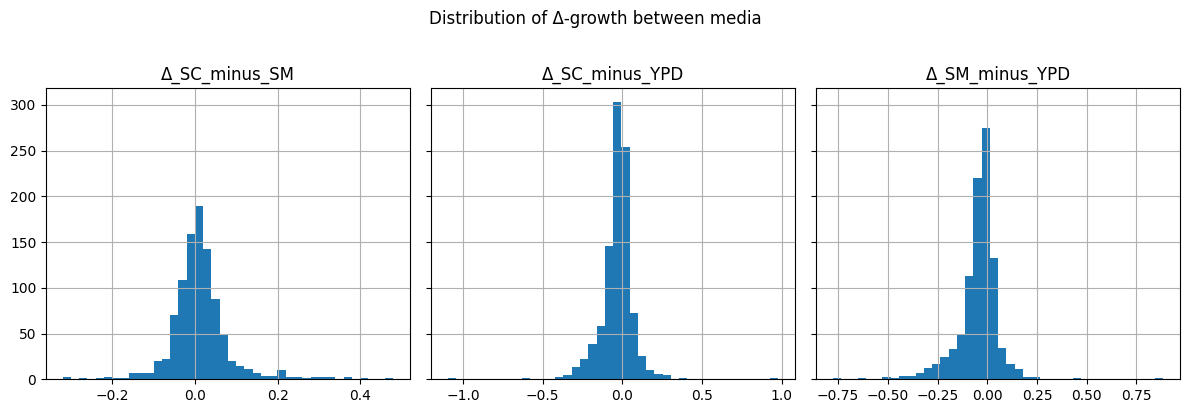

In [16]:
# Histograms of Δ-growth
ax = delta_df.hist(bins=40, figsize=(12, 4), layout=(1, 3), sharey=True)
plt.suptitle("Distribution of Δ-growth between media", y=1.02)
plt.tight_layout()
plt.show()

In [18]:
delta_stats = delta_df.agg(["mean", "median", "std", "min", "max"])
delta_stats

,Δ_SC_minus_SM,Δ_SC_minus_YPD,Δ_SM_minus_YPD
mean,0.012917,-0.032887,-0.045804
median,0.006683,-0.021025,-0.028795
std,0.073093,0.103357,0.103707
min,-0.320453,-1.096435,-0.775982
max,0.479133,0.978760,0.886259


In [ ]:
# 1. Series with gene index
# g_subset_df: index = gene, cols = ["SM", "SC", "YPD"]
SC_messner_by_gene = g_subset_df["SC"]  # Messner SC, index = gene
SM_messner_by_gene = g_subset_df["SM"]  # Messner SM, index = gene

SC_duibhir = pd.read_csv("../data/processed/y_duibhir.csv").set_index("KO")
SC_duibhir_speed = -SC_duibhir["growth"]  # higher = faster, index = gene

# 2. Align on common genes
common_genes = SC_messner_by_gene.index.intersection(SC_duibhir_speed.index)

m_sc = SC_messner_by_gene.loc[common_genes]
m_sm = SM_messner_by_gene.loc[common_genes]
d_sc = SC_duibhir_speed.loc[common_genes]

# 3. Standardise (z-scores) while keeping gene index
m_sm_z = (m_sm - m_sm.mean()) / m_sm.std()
m_sc_z = (m_sc - m_sc.mean()) / m_sc.std()
d_sc_z = (d_sc - d_sc.mean()) / d_sc.std()

# 4. Correlations (genes are matched by index)
pearson_sc = m_sc_z.corr(d_sc_z, method="pearson")
spearman_sc = m_sc_z.corr(d_sc_z, method="spearman")

pearson_sc_sm = m_sm_z.corr(d_sc_z, method="pearson")
spearman_sc_sm = m_sm_z.corr(d_sc_z, method="spearman")

print("SC Messner vs SC Duibhir:")
print("Pearson:", pearson_sc)
print("Spearman:", spearman_sc)
print("--------------------------")
print("SM Messner vs SC Duibhir:")
print("Pearson:", pearson_sc_sm)
print("Spearman:", spearman_sc_sm)

SC Messner vs SC Duibhir:
Pearson: 0.5236393193371065
Spearman: 0.3778722545417069
--------------------------
SM Messner vs SC Duibhir:
Pearson: 0.4982714343803139
Spearman: 0.37897113454091047


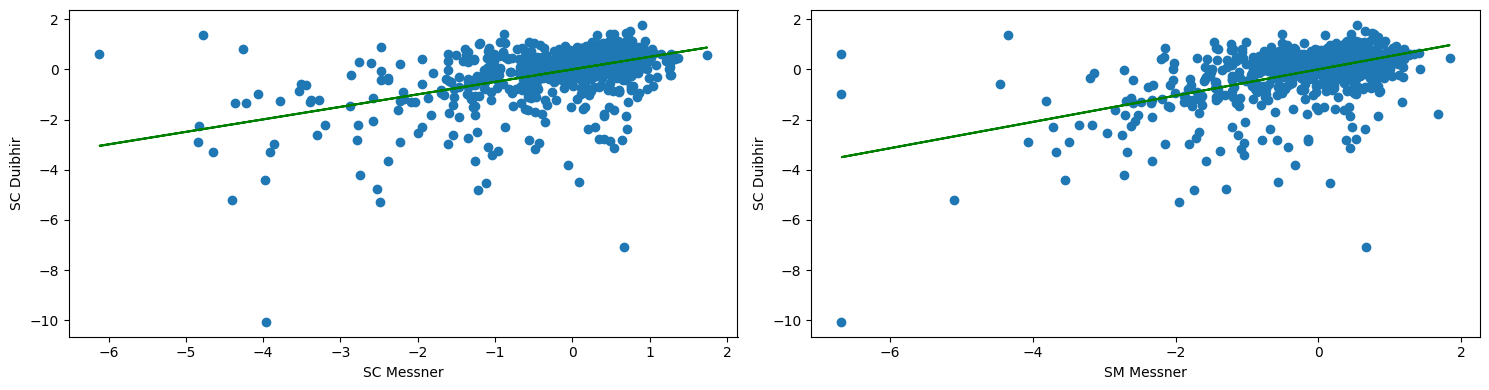

In [36]:
x = m_sm_z
y = m_sc_z
z = d_sc_z
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].scatter(x, z)
axes[0].set_xlabel("SC Messner")
axes[0].set_ylabel("SC Duibhir")
m0, b0 = np.polyfit(x, z, 1)
axes[0].plot(x, m0 * x + b0, color="green")

axes[1].scatter(y, z)
axes[1].set_xlabel("SM Messner")
axes[1].set_ylabel("SC Duibhir")
m1, b1 = np.polyfit(y, z, 1)
axes[1].plot(y, m1 * y + b1, color="green")

plt.tight_layout()
plt.show()